In [1]:
################ Library imports ################
import numpy as np
import math as math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.linalg
import seaborn as sns
import time

import itertools

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

from sklearn.metrics import mean_squared_error, mean_absolute_error
 
from scipy.optimize import curve_fit

from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

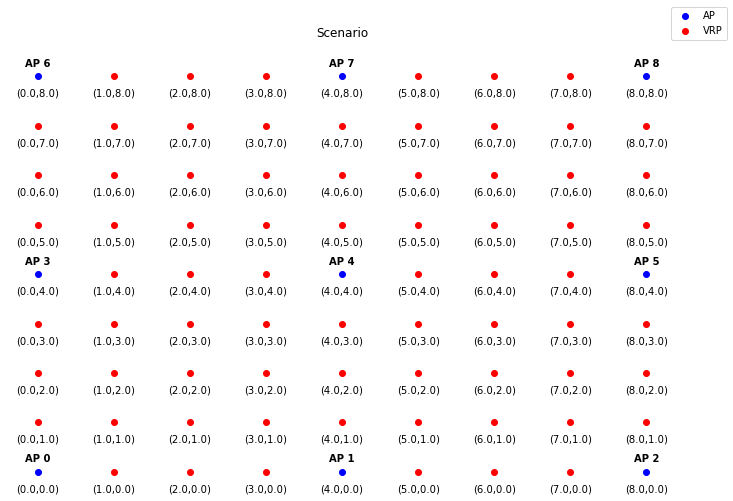

In [2]:
"""
Locations plot
"""
locations = np.array(np.meshgrid(np.linspace(0, 8, 9), np.linspace(0, 8, 9))).T.reshape(-1,2)

# ----------------------------------------------------------------------
#  AP locations
L_ap = locations[[0,4,8,36,40,44,72,76,80],:]
L_ap[:, [1, 0]] = L_ap[:, [0, 1]]

# ----------------------------------------------------------------------
#  VRP locations
L_vrp = np.delete(locations, [0,4,8,36,40,44,72,76,80], 0)
L_vrp[:, [1, 0]] = L_vrp[:, [0, 1]]

plt.figure(figsize=(12,8))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('Scenario',pad=20)
plt.axis('off')

for x,y in zip(locations[:,0],locations[:,1]):

    label = f"({x},{y})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(L_ap[:,0],L_ap[:,1], np.linspace(0, 8, 9).astype(int)):

    label = f"AP {z}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

In [3]:
"""
Compute Euclidean distance between APs
    
    array --> Array of AP/VRP locations
"""
def compute_euclidean_distance(array):
    n = array.shape[0]

    d_mat = [np.linalg.norm(i - j) for (i,j) in itertools.product(array, array)]
    d_mat = np.array(d_mat).reshape((n, n), order='F')

    return d_mat

In [4]:
"""
Target AP to compute algorithm: AP[0,0]

Let's assume an euclidean distance as RTT distance observations
""" 
d_RTT = compute_euclidean_distance(L_ap)

In [5]:
##Select one AP to plot RTT distance observations

In [6]:
menu = widgets.Dropdown(
       options=['0', '1', '2', '3', '4', '5', '6', '7', '8'],
       value='0',
       description='AP:')
menu

Dropdown(description='AP:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8'), value='0')

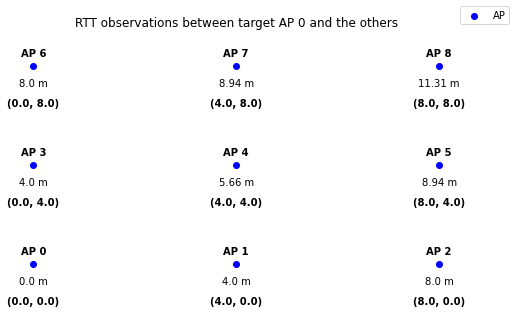

In [7]:
plt.figure(figsize=(8,4))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')

plt.legend(labels=['AP'],loc="upper right",borderaxespad=-5)
plt.title('RTT observations between target AP '+menu.value+' and the others',pad=30)
plt.axis('off')

for x,y,z in zip(L_ap[:,0], L_ap[:,1], d_RTT[:,int(menu.value)]):
    label = f"{z.round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(L_ap[:,0],L_ap[:,1], np.linspace(0, 8, 9).astype(int)):

    label = f"AP {z}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(L_ap[:,0],L_ap[:,1], np.linspace(0, 8, 9).astype(int)):

    label = f"{(x,y)}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-40), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

In [8]:
"""
Polynomial Surface model fitting
    
    loc --> X,Y tuple array of AP locations
    d --> AP RTT distance observations
    order --> Polinomial order
"""
def surface_fit(loc, d, order=1):
    if order == 1:
        A = np.c_[loc[:,0], loc[:,1], np.ones(loc.shape[0])]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    else:
        A = np.c_[np.ones(loc.shape[0]), loc[:,:2], np.prod(loc[:,:2], axis=1), loc[:,:2]**2]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    return C

In [9]:
"""
RTT distance estimation
    
    x --> AP's x locations
    y --> AP's y locations
    C --> Model coefficients
"""
def sample_distance(x, y, C):
    
    XX = x.flatten()
    YY = y.flatten()
    
    if C.shape[0] == 3:
        fit = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(x.shape)
    else:
        fit = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(x.shape)
    return fit

In [10]:
"""
Surface fitting models
"""

# Plot domain
X,Y = np.meshgrid(np.arange(0.0, 9.0, 1), np.arange(0.0, 9.0, 1))

#Models fitting and surface estimation
models_1 = np.array([surface_fit(L_ap, d_RTT[:,i]) for (i) in np.linspace(0, 8, 9).astype(int)])
models_2 = np.array([surface_fit(L_ap, d_RTT[:,i],2) for (i) in np.linspace(0, 8, 9).astype(int)])

Z_1 = np.array([sample_distance(X, Y, models_1[i]) for (i) in np.linspace(0, 8, 9).astype(int)])
Z_2 = np.array([sample_distance(X, Y, models_2[i]) for (i) in np.linspace(0, 8, 9).astype(int)])

In [11]:
##Select one AP to plot fitting model

In [12]:
menu_2 = widgets.Dropdown(
       options=['0', '1', '2', '3', '4', '5', '6', '7', '8'],
       value='0',
       description='AP:')
menu_2

Dropdown(description='AP:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8'), value='0')

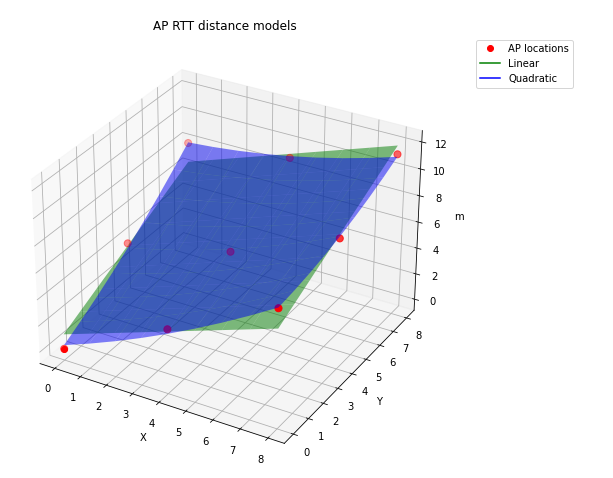

In [13]:
"""
Surface fitting plot
"""
fig = plt.figure(figsize=(12,8))

ax = fig.gca(projection='3d')

l1 = ax.plot_surface(X, Y, Z_1[int(menu_2.value),:,:], rstride=1, cstride=1, alpha=0.5, label='linear', color='g')
l2 = ax.plot_surface(X, Y, Z_2[int(menu_2.value),:,:], rstride=1, cstride=1, alpha=0.5, label='quadratic', color='b')

ax.scatter(L_ap[:,0], L_ap[:,1], d_RTT[:,int(menu_2.value)], c='r', s=50)

plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('m')
ax.axis('auto')

line_labels = ["AP locations","Linear", "Quadratic"]

ax.plot([0], [0], d_RTT[:,int(menu_2.value)][0], color="red", marker='o', linewidth=0)[0]
ax.plot([0], [0], color="green")[0]
ax.plot([0], [0], color="blue")[0]

fig.legend(labels=line_labels,loc="upper right",borderaxespad=4)

plt.title('AP RTT distance models')
plt.show()

In [14]:
"""
Mean RTT distance values at VRPs
    _1 --> Order 1 surface fit
    _2 --> Order 2 surface fit
"""

fit_1 = np.reshape(Z_1, (9,81,1))
fit_2 = np.reshape(Z_2, (9,81,1))

# ----------------------------------------------------------------------
#  Mean RTT observations between target AP and the rest
m_ap_1 = fit_1[:,[0,4,8,36,40,44,72,76,80],:]
m_ap_2 = fit_2[:,[0,4,8,36,40,44,72,76,80], :]
vrp_pts = np.delete(np.linspace(0, 80, 81).astype(int), [0,4,8,36,40,44,72,76,80], 0)

# ----------------------------------------------------------------------
#  Mean RTT observations between target AP and VRPs
m_vrp_1 = fit_1[:,vrp_pts,:]
m_vrp_2 = fit_2[:,vrp_pts,:]

In [15]:
##Select one AP to plot RTT Mean distances

In [16]:
menu_3 = widgets.Dropdown(
       options=['0', '1', '2', '3', '4', '5', '6', '7', '8'],
       value='0',
       description='AP:')
menu_3

Dropdown(description='AP:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8'), value='0')

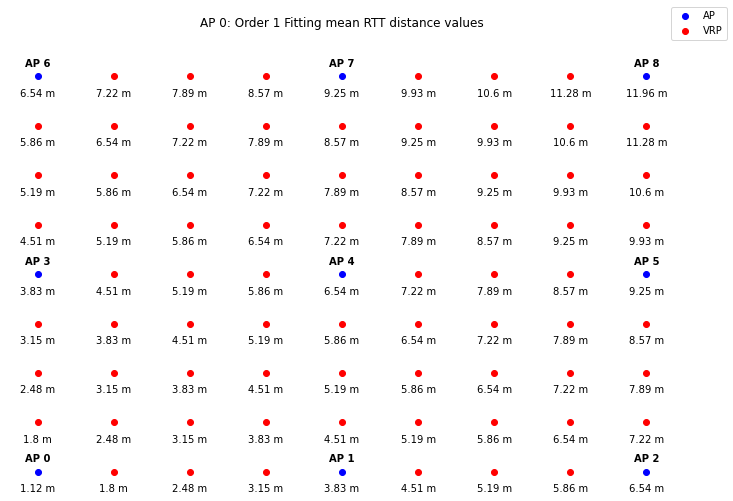

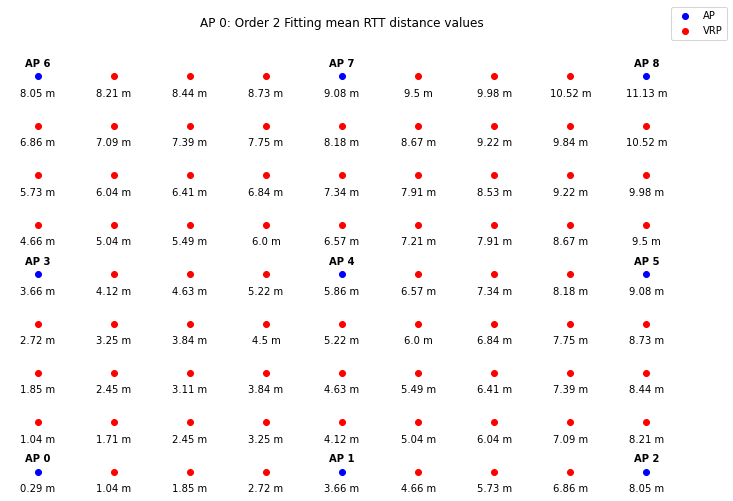

In [17]:
"""
Order 1 RTT Mean distance plot
"""
plt.figure(figsize=(12,8))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('AP '+menu_3.value+': Order 1 Fitting mean RTT distance values',pad=30)
plt.axis('off')

for x,y in zip(locations[:,0],locations[:,1]):
    label = f"{sample_distance(x, y, models_1[int(menu_3.value)]).round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(L_ap[:,0],L_ap[:,1], np.linspace(0, 8, 9).astype(int)):

    label = f"AP {z}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

"""
Order 2 RTT Mean distance plot
"""
plt.figure(figsize=(12,8))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('AP '+menu_3.value+': Order 2 Fitting mean RTT distance values',pad=30)
plt.axis('off')

for x,y in zip(locations[:,0],locations[:,1]):
    label = f"{sample_distance(x, y, models_2[int(menu_3.value)]).round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(L_ap[:,0],L_ap[:,1], np.linspace(0, 8, 9).astype(int)):

    label = f"AP {z}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

In [18]:
"""
Gaussian Process Kernel definition

Kernel parameters:
    - L --> Length Scale
    - sigma_f --> Constant Kernel Amplitude
"""

def kernel_function(x, y, sigma_f=1, l=1):

    """ Squared Exponential kernel function """
    kernel = sigma_f * np.exp(- (np.linalg.norm(x - y)**2) / (2 * l**2))
    return kernel

In [19]:
"""
Hyperparameter optimization of sigma_f and length-scale

    loc --> AP locations
    mean --> RTT distance observations between APs
"""
def gp_fit(loc, mean):
    
    gp.fit(loc, mean)

    l = gp.kernel_.get_params().get('k2__length_scale')
    sigma_f = gp.kernel_.get_params().get('k1__constant_value')
    return l, sigma_f

In [20]:
"""
Gaussian Process Fit using scikit-learn GPR
"""
sigma_n = 0.0

kernel = ConstantKernel(constant_value=1.0,constant_value_bounds=(1e-3, 1e3)) \
            * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))

gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10)

hyper_params = np.array([gp_fit(L_ap, d_RTT[:,i]) for (i) in np.linspace(0, 8, 9).astype(int)])

In [21]:
def compute_cov_matrices(L_ap, L_vrp, sigma_f=1, l=1):
    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
    
        - K = K(L, L) 
        - K_star = K(L^*, L)
        - K_star2 = K(L^*, L^*)
    """
    n = L_ap.shape[0]
    n_star = L_vrp.shape[0]

    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(L_ap, L_ap)]

    K = np.array(K).reshape(n, n)
    
    K_star2 = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(L_vrp, L_vrp)]

    K_star2 = np.array(K_star2).reshape(n_star, n_star)
    
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(L_vrp, L_ap)]

    K_star = np.array(K_star).reshape(n_star, n)
    
    return (K, K_star2, K_star)

In [22]:
class Regressor:
    '''
    Handles the required structures to compute GPR interpolation

            Parameters:
                    K (ndarray): Covariance matrix between AP locations
                    K_star2 (ndarray): Covariance matrix between VRP locations
                    K_star (ndarray): Covariance matrix between each AP location and each VRP location
                    m_ap (ndarray): Mean RTT distance values at AP locations from fitting model
                    m_vrp (ndarray): Mean RTT distance values at VRP locations from fitting model
    '''
    def __init__(self, _K, _K_star2, _K_star, _m_ap, _m_vrp, _m_ap2, _m_vrp2):
        self.K = _K
        self.K_star2 = _K_star2
        self.K_star = _K_star
        self.m_ap = _m_ap
        self.m_vrp = _m_vrp
        self.m_ap2 = _m_ap2
        self.m_vrp2 = _m_vrp2


In [23]:
"""
Gaussian Process Regressor definition:

    - Covariance matrices: K, K_star, K_star2
    - Mean distance values: m_ap, m_vrp 
"""

list = []

for i in np.linspace(0, 8, 9).astype(int):
    a, b, c = compute_cov_matrices(L_ap, L_vrp, sigma_f=hyper_params[i][1], l=hyper_params[i][0])
    gpr = Regressor(a,b,c,m_ap_1[i],m_vrp_1[i],m_ap_2[i],m_vrp_2[i])
    list.append(gpr)

##Select one AP to view Covariance Matrices

In [24]:
menu_4 = widgets.Dropdown(
       options=['0', '1', '2', '3', '4', '5', '6', '7', '8'],
       value='0',
       description='AP:')
menu_4

Dropdown(description='AP:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8'), value='0')

In [25]:
"""
Multivariate Joint Distribution: G matrix
"""

n = L_ap.shape[0]
n_star = L_vrp.shape[0]

a = np.concatenate((list[int(menu_4.value)].K + (sigma_n**2)*np.eye(n), list[int(menu_4.value)].K_star), axis=0)
print(a.shape)
b = np.concatenate((list[int(menu_4.value)].K_star.T, list[int(menu_4.value)].K_star2), axis=0)
print(b.shape)
G = np.concatenate((a, b), axis=1)
print(G.shape)
G.shape == (n + n_star, n + n_star)

(81, 9)
(81, 72)
(81, 81)


True

[Text(0.5, 1.0, 'AP 0 : Components of the Kernel Covariance Matrix K(L,L)')]

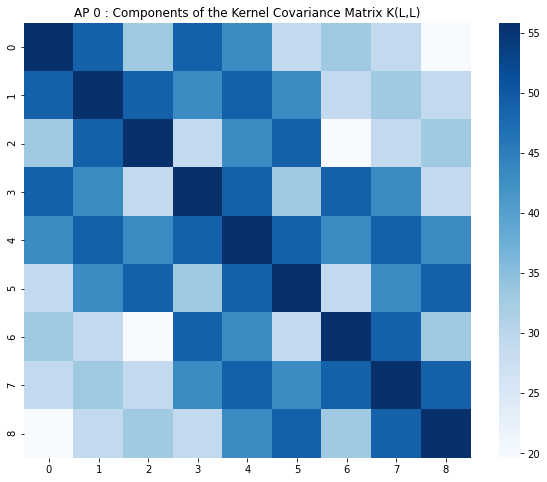

In [26]:
"""
Kernel Covariance Matrix K(L,L)
"""
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=list[int(menu_4.value)].K, cmap='Blues', ax=ax)
ax.set(title='AP '+menu_4.value+' : Components of the Kernel Covariance Matrix K(L,L)')

[Text(0.5, 1.0, 'AP 0 : Components of the Kernel Covariance Matrix K(L*,L*)')]

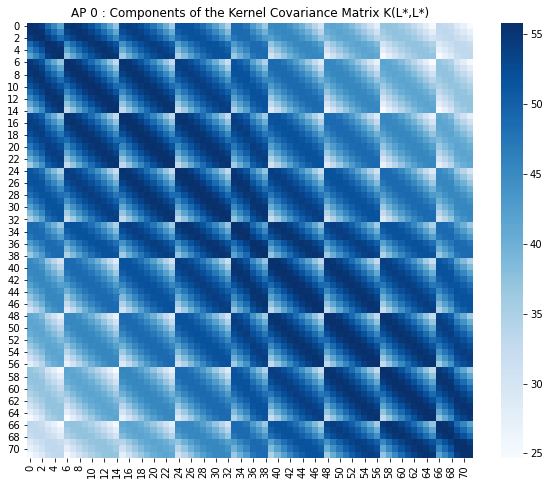

In [27]:
"""
Kernel Covariance Matrix K(L*,L*)
"""
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=list[int(menu_4.value)].K_star2, cmap='Blues', ax=ax)
ax.set(title='AP '+menu_4.value+' : Components of the Kernel Covariance Matrix K(L*,L*)')

[Text(0.5, 1.0, 'AP 0 : Components of the Kernel Covariance Matrix K(L*,L)')]

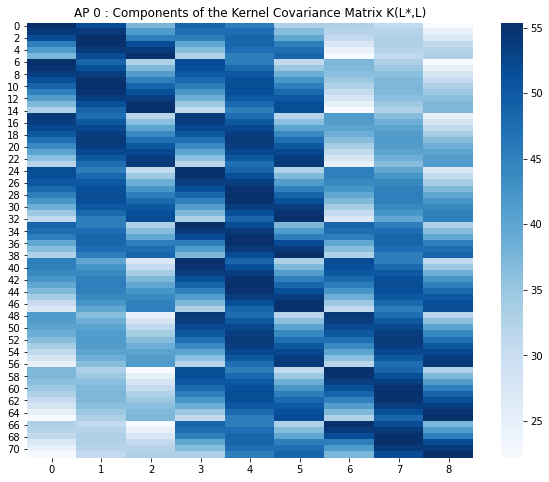

In [28]:
"""
Kernel Covariance Matrix K(L*,L)
"""
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=list[int(menu_4.value)].K_star, cmap='Blues', ax=ax)
ax.set(title='AP '+menu_4.value+' : Components of the Kernel Covariance Matrix K(L*,L)')

In [29]:
def psfm_gpr_parameters(m, m_star, d, K, K_star2, K_star, sigma_n):
    
    """Compute gaussian regression parameters."""

    n = K.shape[0]
    n_star = K_star.shape[0]
    
    # Mean.
    s_bar_star = (m_star.reshape([n_star, 1]) 
        + np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), d.reshape([n, 1]) - m.reshape([n, 1]))))
    # Covariance.
    cov_s_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (s_bar_star.reshape(n_star), cov_s_star)

In [30]:
def zero_mean_gpr_parameters(d, K, K_star2, K_star, sigma_n):
    
    """Compute gaussian regression parameters."""

    n = K.shape[0]
    n_star = K_star.shape[0]

    # Mean.
    s_bar_star = np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), d.reshape([n, 1])))
    # Covariance.
    cov_s_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (s_bar_star.reshape(n_star), cov_s_star)

In [31]:
"""
Zero-Mean Gaussian Process interpolations
"""
n = L_ap.shape[0]
n_star = L_vrp.shape[0]

means = np.empty((n, n_star, 1))
variances = np.empty((n, n_star, 1))

for i in np.linspace(0, 8, 9).astype(int):

    s_bar_star, cov_s_star = zero_mean_gpr_parameters(d_RTT[:,i], list[i].K, list[i].K_star2, list[i].K_star, sigma_n)
    var_s_star = np.diag(cov_s_star)

    means[i,:,:] = s_bar_star.reshape(n_star,1)
    variances[i,:,:] = var_s_star.reshape(n_star,1)

In [32]:
"""
Order 1 PSFM Gaussian Process interpolations
"""
means_psfm = np.empty((n, n_star, 1))

for i in np.linspace(0, 8, 9).astype(int):
    s_bar_star, cov_s_star = psfm_gpr_parameters(list[i].m_ap,list[i].m_vrp, d_RTT[:,i], list[i].K, list[i].K_star2, list[i].K_star, sigma_n)
    means_psfm[i,:,:] = s_bar_star.reshape(n_star,1)

In [33]:
"""
Order 2 PSFM Gaussian Process interpolations
"""
means_psfm2 = np.empty((n, n_star, 1))

for i in np.linspace(0, 8, 9).astype(int):
    s_bar_star, cov_s_star = psfm_gpr_parameters(list[i].m_ap2,list[i].m_vrp2, d_RTT[:,i], list[i].K, list[i].K_star2, list[i].K_star, sigma_n)
    means_psfm2[i,:,:] = s_bar_star.reshape(n_star,1)

In [34]:
##Select one AP to plot Gaussian Process Interpolations

In [35]:
menu_5 = widgets.Dropdown(
       options=['0', '1', '2', '3', '4', '5', '6', '7', '8'],
       value='0',
       description='AP:')
menu_5

Dropdown(description='AP:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8'), value='0')

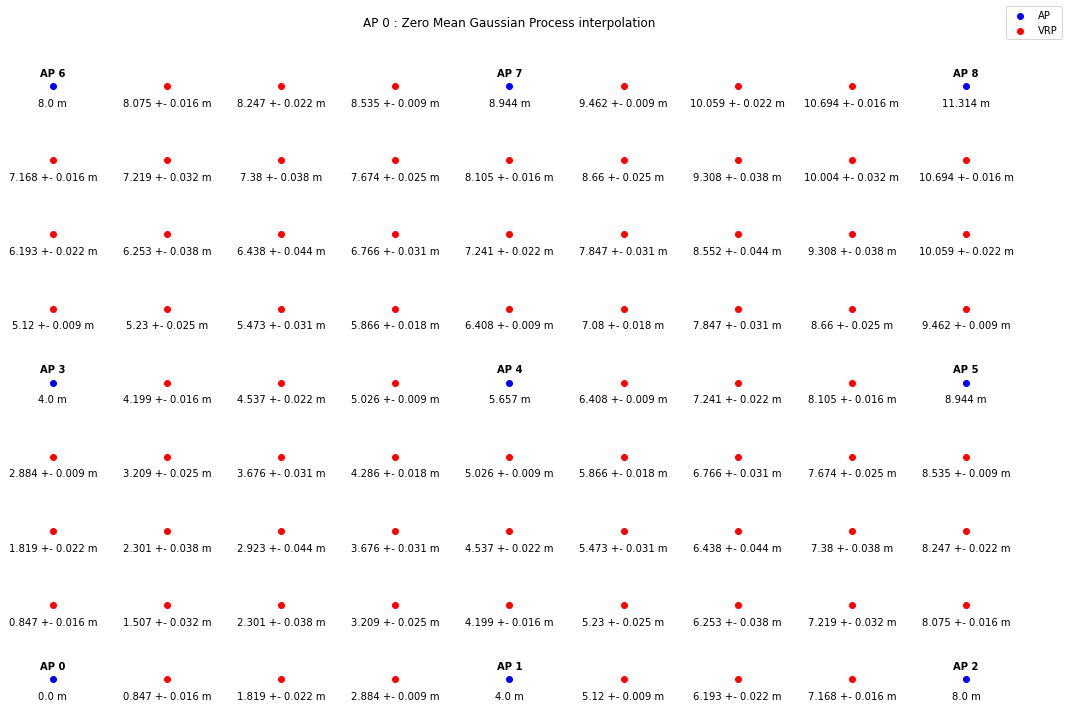

In [36]:
"""
Zero Mean Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(18,12))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('AP '+menu_5.value+' : Zero Mean Gaussian Process interpolation',pad=30)
plt.axis('off')

for x in range(len(d_RTT[:,int(menu_5.value)])):
    label = f"{d_RTT[:,int(menu_5.value)][x].round(3)} m"

    plt.annotate(label, # this is the text
                 (L_ap[x,0],L_ap[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(means[int(menu_5.value)])):
    label = f"{means[int(menu_5.value)][x,0].round(3)} +- {variances[int(menu_5.value)][x,0].round(3)} m"

    plt.annotate(label, # this is the text
                 (L_vrp[x,0],L_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(L_ap[:,0],L_ap[:,1], np.linspace(0, 8, 9).astype(int)):

    label = f"AP {z}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

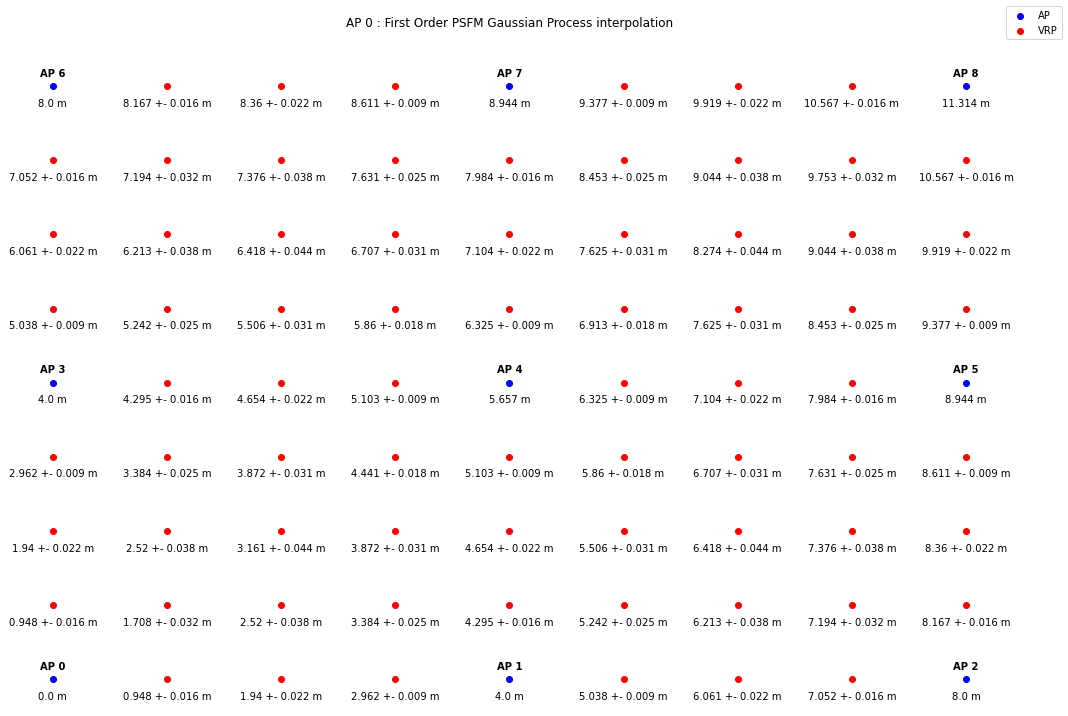

In [37]:
"""
First Order PSFM Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(18,12))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('AP '+menu_5.value+' : First Order PSFM Gaussian Process interpolation',pad=30)
plt.axis('off')

for x in range(len(d_RTT[:,int(menu_5.value)])):
    label = f"{d_RTT[:,int(menu_5.value)][x].round(3)} m"

    plt.annotate(label, # this is the text
                 (L_ap[x,0],L_ap[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(means_psfm[int(menu_5.value)])):
    label = f"{means_psfm[int(menu_5.value)][x,0].round(3)} +- {variances[int(menu_5.value)][x,0].round(3)} m"

    plt.annotate(label, # this is the text
                 (L_vrp[x,0],L_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(L_ap[:,0],L_ap[:,1], np.linspace(0, 8, 9).astype(int)):

    label = f"AP {z}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

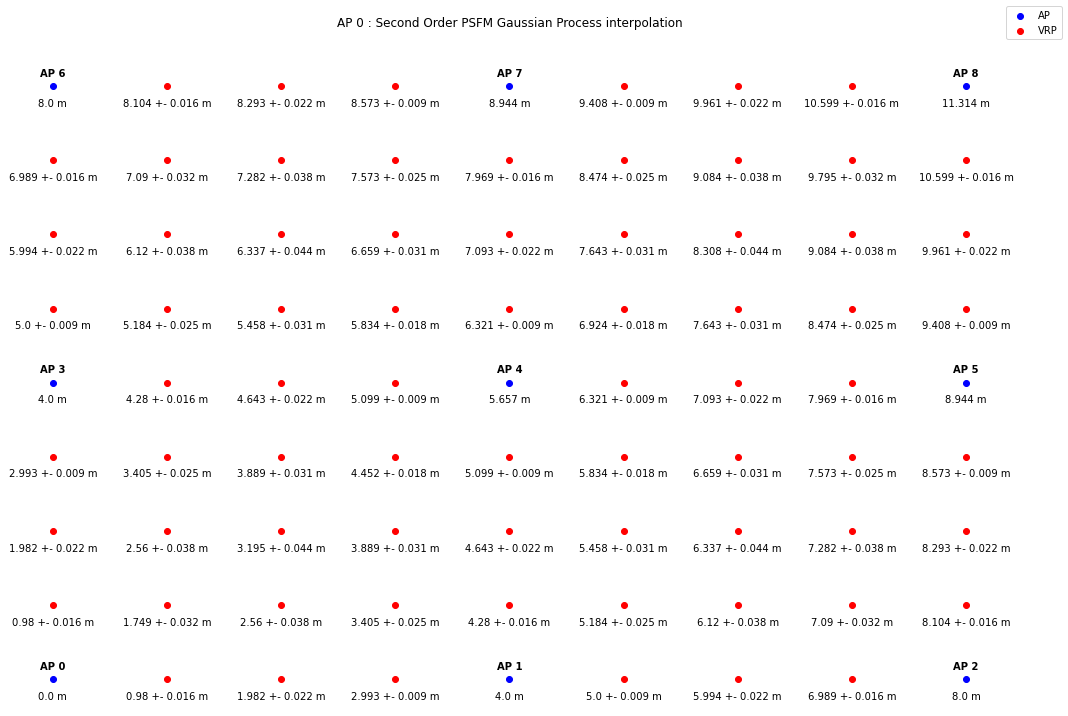

In [38]:
"""
Second Order Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(18,12))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('AP '+menu_5.value+' : Second Order PSFM Gaussian Process interpolation',pad=30)
plt.axis('off')

for x in range(len(d_RTT[:,int(menu_5.value)])):
    label = f"{d_RTT[:,int(menu_5.value)][x].round(3)} m"

    plt.annotate(label, # this is the text
                 (L_ap[x,0],L_ap[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(means_psfm2[int(menu_5.value)])):
    label = f"{means_psfm2[int(menu_5.value)][x,0].round(3)} +- {variances[int(menu_5.value)][x,0].round(3)} m"

    plt.annotate(label, # this is the text
                 (L_vrp[x,0],L_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(L_ap[:,0],L_ap[:,1], np.linspace(0, 8, 9).astype(int)):

    label = f"AP {z}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

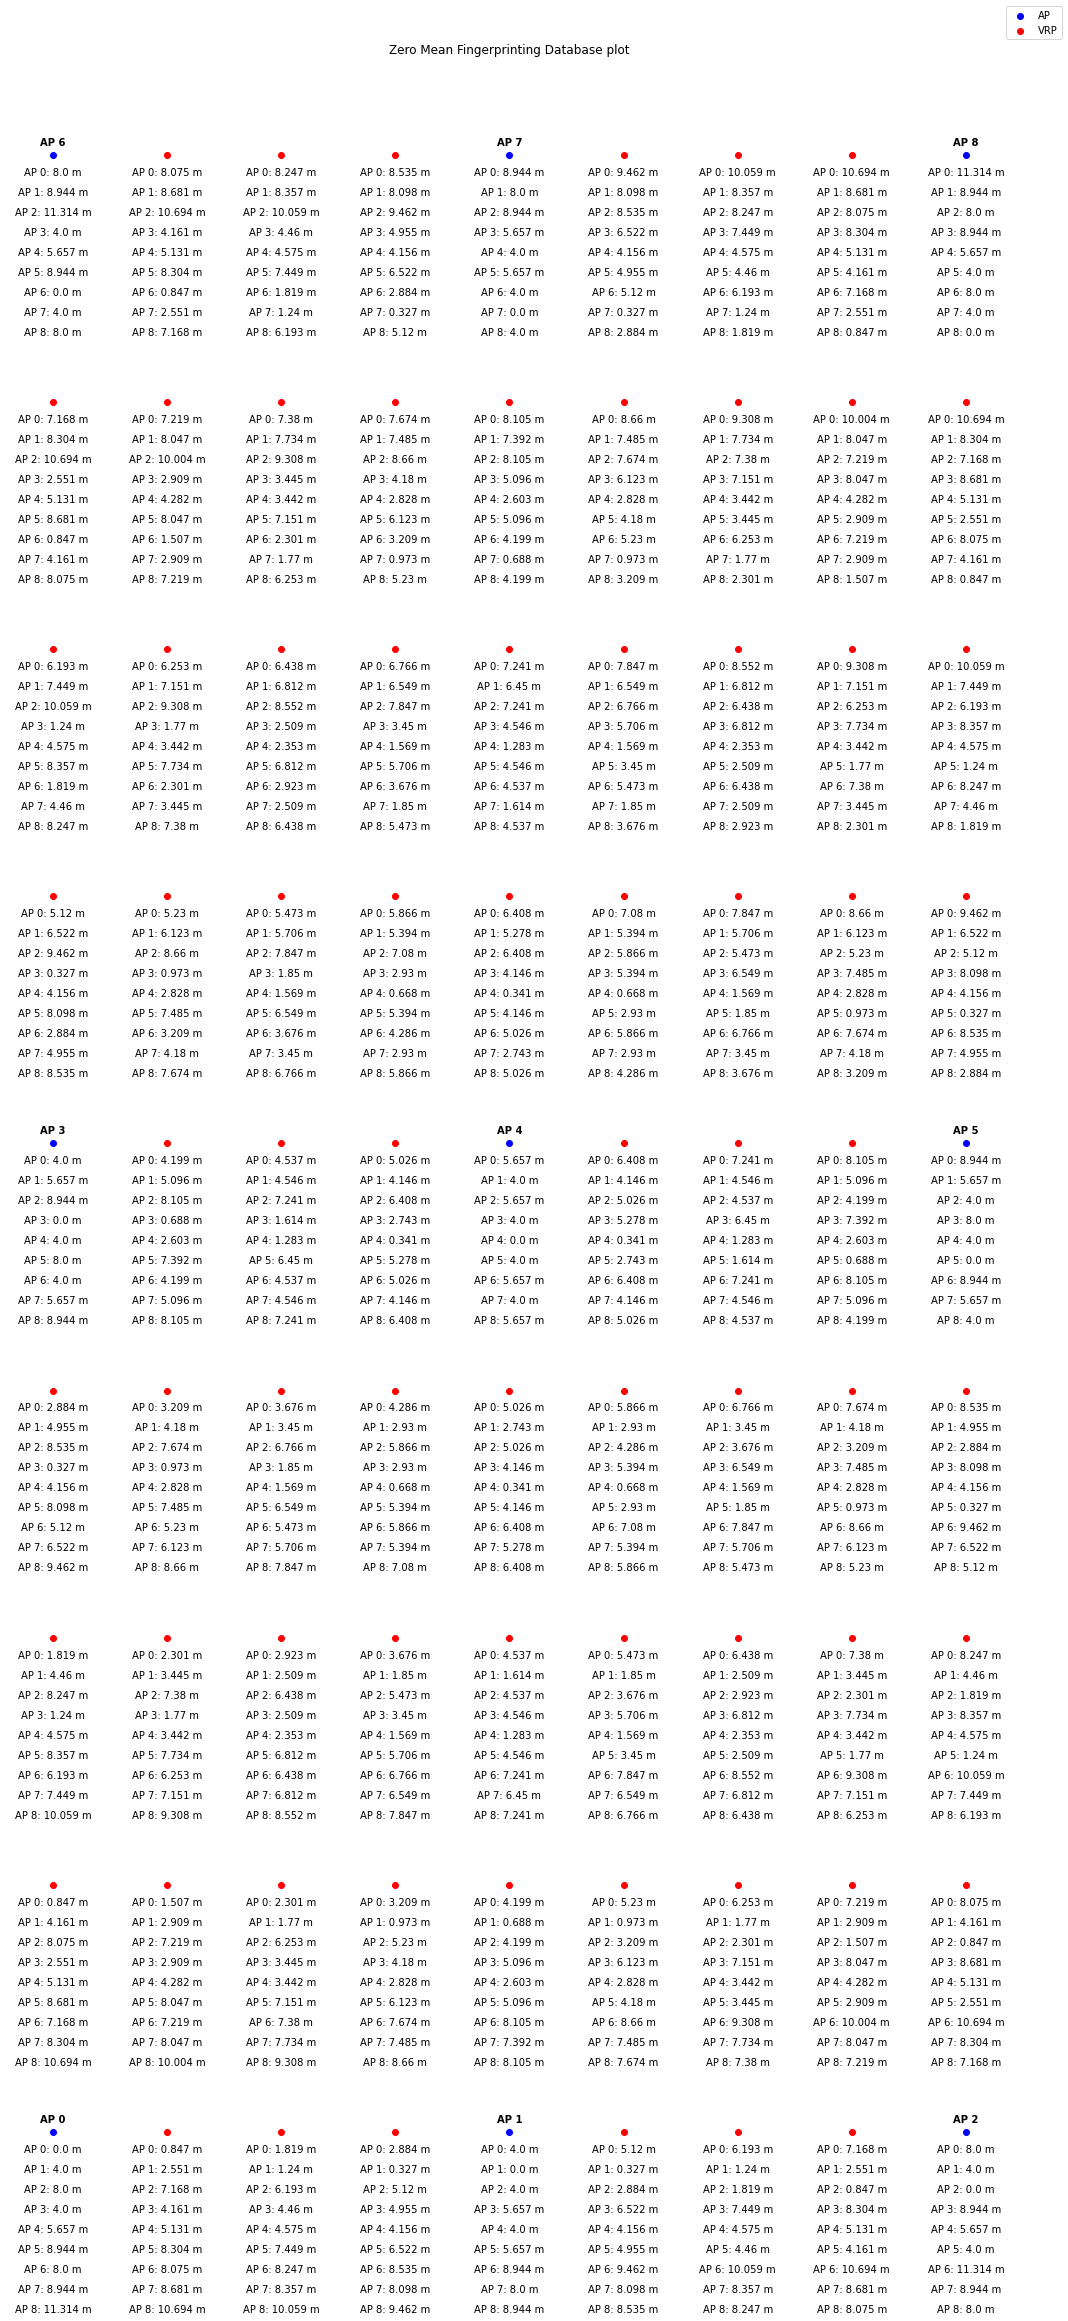

In [55]:
"""
Zero Mean GPR Fingerprinting Database plot
"""

plt.figure(figsize=(18,40))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('Zero Mean Fingerprinting Database plot', pad=0)
plt.axis('off')

for x in range(len(d_RTT[int(menu_5.value)])):
    for y in range(len(d_RTT[int(menu_5.value)])):
        label = f"AP {y}: {d_RTT[x,y].round(3)} m"

        plt.annotate(label, # this is the text
                    (L_ap[x,0],L_ap[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-20-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

for x in range(len(means[int(menu_5.value)])):
    for y in range(len(d_RTT[int(menu_5.value)])):
        label = f"AP {y}: {means[:,x,:][y,0].round(3)} m"

        plt.annotate(label, # this is the text
                    (L_vrp[x,0],L_vrp[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-20-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(L_ap[:,0],L_ap[:,1], np.linspace(0, 8, 9).astype(int)):

    label = f"AP {z}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')